# Setting up the functions to build the models

In [3]:
def build_model(mass=None, object_redshift=None, ldist=10.0, fixed_metallicity=None, add_duste=False, **extras):
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors
    
    model_params = TemplateLibrary['parametric_sfh']
    
    # If necessary, this is the step where you would need to change the initial values for the parameters
    model_params['lumdist'] = {'N':1, 'isfree':False, 'init':ldist, 'units':'Mpc'}
    model_params['zred']['init'] = 0.0
    model_params['dust2']['init'] = 0.05
    model_params['logzsol']['init'] = -0.5
    model_params['tage']['init'] = 13.
    
    # Make it so this parameter can be varied
    if mass == None:
        model_params['mass']['init'] = 1e8
        model_params['mass']['prior'] = priors.LogUniform(mini=1e6, maxi=1e10)
        model_params['mass']['disp_floor'] = 1e6
    else:
        model_params['mass']['init'] = mass
        model_params['mass']['prior'] = priors.LogUniform(mini=10**(np.log10(mass)-2), maxi=10**(np.log10(mass)+2))
        model_params['mass']['disp_floor'] = 10**(np.log10(mass)-2)
    
    # Changing the priors for some of the free parameters
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params['tau']['prior'] = priors.LogUniform(mini=1e-1, maxi=1e2)
    
    # Providing minimum scale for the cloud of walkers for emcee
    model_params['tau']['disp_floor'] = 1.0
    model_params['tage']['disp_floor'] = 1.0
    
    # If optional (**extras) parameters are provided...
    if fixed_metallicity is not None:
        model_params['logzsol']['isfree'] = False
        # make it a fixed parameter
        model_params['logzsol']['init'] = fixed_metallicity
        
    if object_redshift is not None:
        model_params['zred']['isfree'] = False
        # make it a fixed parameter
        model_params['zred']['init'] = object_redshift
    
    if add_duste:
        model_params.update(TemplateLibrary['dust_emission'])
        
    model = SedModel(model_params)
    
    return model

# -------------------------------------------------------------------------------------------------------------------

# Building the SPS function
def build_sps(zcontinuous=1, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

# -------------------------------------------------------------------------------------------------------------------

# Building the observations function
def getObs(snr=10, ldist=10.0, obj=[], **extras_):
    
    from prospect.utils.obsutils import fix_obs
    import sedpy
    import numpy as np
    
    # obs is a dictionary of observational data to use for the fit
    obs = {}
    
    galex = ['galex_'+a for a in ['FUV', 'NUV']]
    sdss = [f'sdss_{c}0' for c in ['u', 'g', 'r', 'i', 'z']]
    spitzer = ['spitzer_irac_ch'+b for b in ['1', '2', '3', '4']]
    filternames = galex + sdss + spitzer
    
    obs['filters'] = sedpy.observate.load_filters(filternames)
    
    M_AB = np.array(obj)

    dm = 25 + 5.0 * np.log10(ldist)
    mags = M_AB + dm
    
    obs['maggies'] = 10**(-0.4*mags)
    obs['maggies_unc'] = (1./snr) * obs['maggies']
    
    obs['phot_mask'] = np.array(['spitzer' not in f.name for f in obs['filters']])
    obs['phot_wave'] = np.array([f.wave_effective for f in obs['filters']])

    obs['wavelength'] = None
    obs['spectrum'] = None
    obs['unc'] = None
    obs['mask'] = None
    
    obs = fix_obs(obs)
    
    return obs

------------------------

# Setting up the models to cover a range of masses

In [4]:
# Import statements
import numpy as np
import time
from matplotlib.pyplot import *

In [22]:
start = time.time()
masses = np.logspace(9, 13, num=5)
keys = ['model_'+str(_) for _ in range(1,len(masses)+1)]
models = {key: {} for key in keys}
theta_names = ['theta_'+str(_) for _ in range(1,len(masses)+1)]
thetas = {name: {} for name in theta_names}
datum = {key: {'init_spec':[], 'init_phot':[], 'init_mfrac':[]} for key in keys}

run_params = {}
run_params['snr'] = 10.0
run_params['ldist'] = 10.0
run_params['object_redshift'] = 0.0
run_params['fixed_metallicity'] = None
run_params['add_duste'] = True
run_params['zcontinuous'] = 1
sps = build_sps(**run_params)

run_params['obj'] = [-11.36,  -11.36, -11.65, -12.15, -12.38, -12.43, -12.66, -11.53, -11.21, -10.79, -10.82]
run_params['snr'] = 10.0
run_params['ldist'] = 10.0
obs = getObs(**run_params)

for mass,key,name in zip(masses,keys,theta_names):
#     print(key, models[key], mass)
    models[key] = build_model(mass=mass,**run_params)
    thetas[name] = models[key].theta.copy()
#     data1, data2, data3 = models[key].sed(theta, obs=obs, sps=sps)
    datum[key]['init_spec'], datum[key]['init_phot'], datum[key]['init_mfrac'] = models[key].sed(thetas[name], obs=obs, sps=sps)

# print(models['model_1'].sed(thetas['theta_1'], obs=obs, sps=sps))
# data
# theta = model.theta.copy()
# initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
end = time.time()
print(end-start)

48.11119890213013


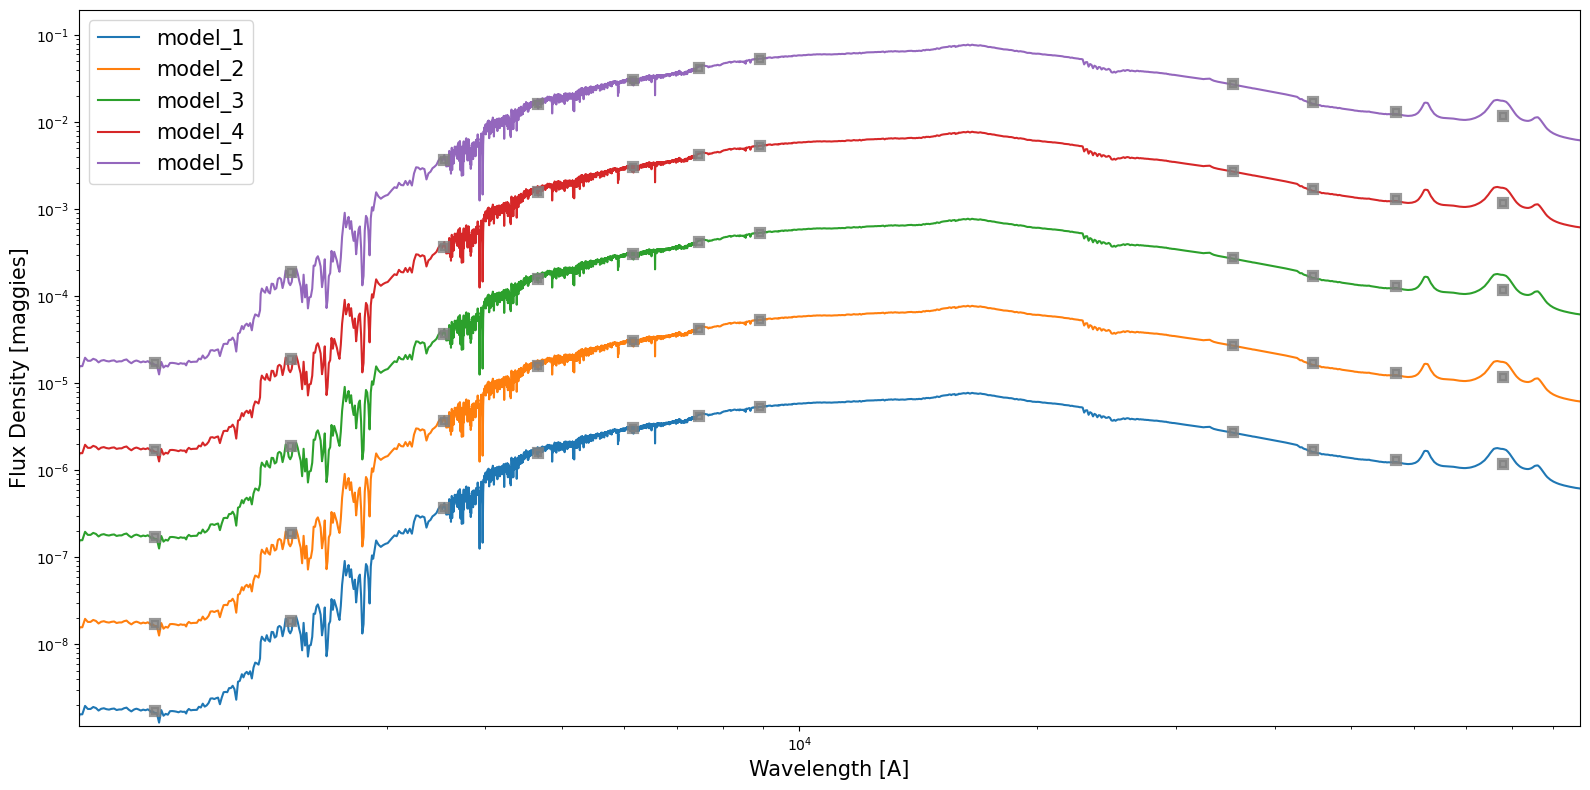

In [32]:
from matplotlib.pyplot import *

figure(figsize=(16,8))

wphot = obs['phot_wave']

for key in keys:   
    a = 1.0 + models[key].params.get('zred',0.0)
    
    if obs['wavelength'] is None:
        wspec = sps.wavelengths
        wspec *= a
    else:
        wspec = obs['wavelength']
    
    loglog(wspec, datum[key]['init_spec'], label=key)
#     plot(wphot, datum[key]['init_phot'], label=key, marker='o')
    
    errorbar(wphot, datum[key]['init_phot'], marker='s', 
             color='gray', alpha=0.8, ls='', lw=3, markeredgewidth=3)

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, datum['model_1']['init_spec']) # Hardcoded to be the smallest mass
ymin = temp.min()*0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, datum['model_5']['init_spec']) # Hardcoded to be the largest mass
ymax = temp.max()/0.4
    
xlabel('Wavelength [A]', fontsize=15)
ylabel('Flux Density [maggies]', fontsize=15)
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale('log')
yscale('log')
legend(fontsize=15)

tight_layout()
show()